<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/4_PyTorch_Avanzado/1_modelos_personalizados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
# Modelos Personalizados en Pytorch

Hasta ahora, hemos introducido algunos conceptos básicos de machine learning, avanzando hacia modelos de deep learning completamente funcionales. Para llegar tan lejos tan rápido, recurrimos a Pytorch, un framework de Deep Learning, pero pasamos por alto los detalles más avanzados sobre cómo funciona. 

En esta clase, abriremos el telón, profundizaremos en los componentes clave del cómputo en deep learning, a saber, la construcción de modelos, el acceso a los parámetros y la inicialización, el diseño de capas y bloques personalizados, la lectura y escritura de modelos en el disco y el aprovechamiento de las GPU para lograr resultados con aceleraciones espectaculares. Estos conocimientos nos llevarán de usuario final a usuario avanzado, brindándonos las herramientas necesarias para aprovechar los beneficios de un framework maduro de aprendizaje profundo mientras conservamos la flexibilidad para implementar modelos más complejos, ¡incluidos los que inventemos nosotros mismos! 

# Bloques



Cuando introdujimos las redes neuronales por primera vez, nos enfocamos en modelos lineales con una sola salida.

Aquí, todo el modelo consta de una sola neurona. Tenga en cuenta que una sola neurona
1. toma algún conjunto de entradas;
2. genera una salida escalar correspondiente; y
3. tiene un conjunto de parámetros asociados que pueden actualizarse para optimizar alguna función objetivo de interés.

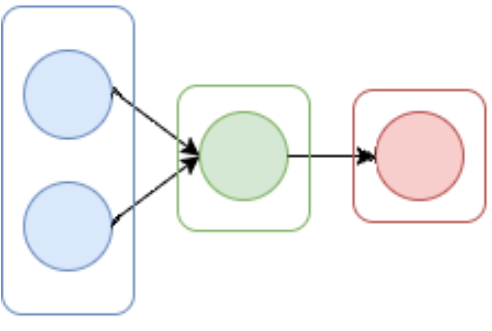



Luego, una vez que comenzamos a pensar en redes con múltiples salidas, aprovechamos la aritmética vectorizada para caracterizar una capa completa de neuronas. Al igual que las neuronas individuales, las capas
1. toma algún conjunto de entradas;
2. genera una salida escalar correspondiente; y
3. tiene un conjunto de parámetros asociados que pueden actualizarse para optimizar alguna función objetivo de interés.

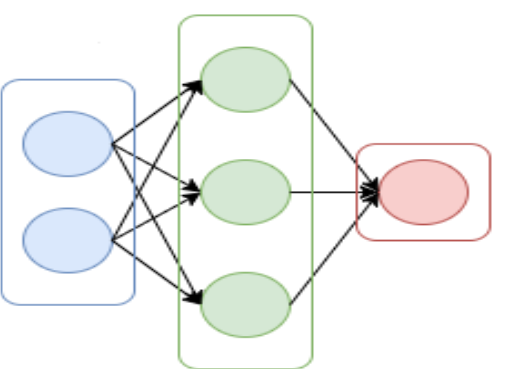

Cuando trabajamos con la regresión softmax, una sola capa era en sí misma el modelo. Sin embargo, incluso cuando posteriormente introdujimos los MLP, aún podíamos pensar que el modelo conservaba esta misma estructura básica.

1. toma algún conjunto de entradas;
2. genera una salida escalar correspondiente; y
3. tiene un conjunto de parámetros asociados que se pueden actualizar para optimizar alguna función objetiva de interés.



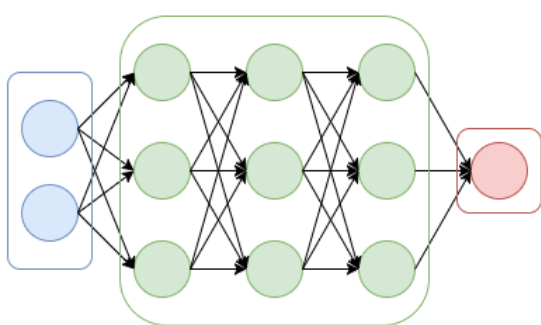

Si bien podría pensar que las neuronas, las capas y los modelos
darnos suficientes abstracciones para seguir con nuestro negocio,
Resulta que a menudo nos resulta conveniente hablar de componentes que son más grandes que una capa individual pero más pequeños que el modelo completo.

La mayoría de las arquitecturas muy populares en visión artificial,
Posee cientos de capas. Estas capas consisten en patrones repetidos de *grupos de capas*. Implementar una red de este tipo una capa a la vez puede volverse tedioso. Esta preocupación no es solo hipotética, tales patrones de diseño son comunes en la práctica.

Arquitecturas similares en las que las capas se organizan en varios patrones repetitivos ahora son omnipresentes en otros dominios, incluido el procesamiento del lenguaje natural y el habla.

Para implementar estas redes complejas, presentamos el concepto de una red neuronal *bloque*. ¡Un bloque podría describir una sola capa, un componente que consta de varias capas o el modelo completo en sí! Una ventaja de trabajar con la abstracción de bloques es que se pueden combinar en artefactos más grandes, a menudo recursivamente. Esto se ilustra en :numref:`fig_blocks`. Al definir el código para generar bloques de complejidad arbitraria bajo demanda, podemos escribir un código sorprendentemente compacto y aun así implementar redes neuronales complejas.



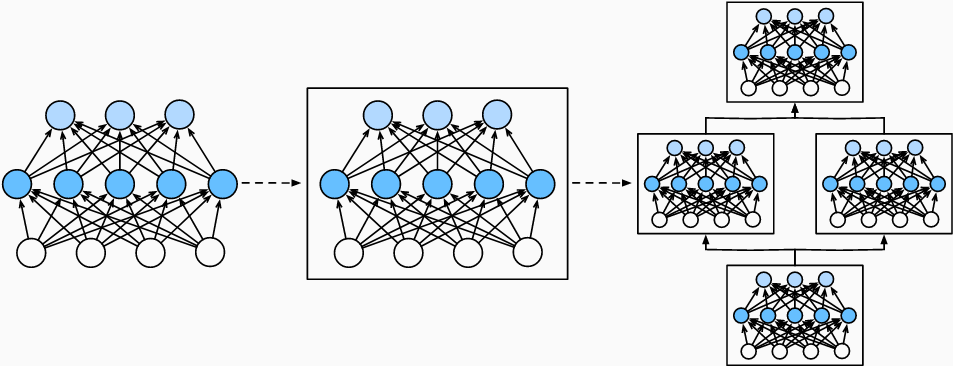




Desde el punto de vista de la programación, un bloque está representado por una *clase*. Cualquier subclase debe definir una función de propagación directa que transforme su entrada en salida y debe almacenar los parámetros necesarios. Tenga en cuenta que algunos bloques no requieren ningún parámetro en absoluto. Finalmente, un bloque debe poseer una función de retropropagación,
para fines de cálculo de gradientes. Afortunadamente, debido a la magia detrás de escena proporcionada por la diferenciación automática (introducida en :numref:`sec_autograd`) al definir nuestro propio bloque, solo debemos preocuparnos por los parámetros y la función de propagación hacia adelante.

**Para comenzar, revisamos el código que usamos para implementar MLPs** (:numref:`sec_mlp_concise`). El siguiente código genera una red con una capa oculta completamente conectada con 256 unidades y activación de ReLU, seguida de una capa de salida completamente conectada con 10 unidades (sin función de activación).

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-0.0275,  0.0889, -0.1878, -0.0165,  0.0356, -0.3514, -0.0725,  0.0725,
          0.0508, -0.0560],
        [ 0.0224,  0.0984, -0.2499,  0.0313,  0.1201, -0.5500, -0.1515,  0.1012,
          0.0086, -0.0528]], grad_fn=<AddmmBackward0>)

En este ejemplo, construimos nuestro modelo instanciando un `nn.Sequential`, con capas en el orden en que deberían ejecutarse pasadas como argumentos. En resumen, (**`nn.Sequential` define un tipo especial de `Módulo`**), la clase que presenta un bloque en PyTorch. Mantiene una lista ordenada de 'Módulos' constituyentes. Tenga en cuenta que cada una de las dos capas completamente conectadas es una instancia de la clase 'Lineal', que a su vez es una subclase de 'Módulo'. La función de propagación hacia adelante ("forward") también es notablemente simple: encadena cada bloque en la lista, pasando la salida de cada uno como entrada al siguiente.
Tenga en cuenta que hasta ahora, hemos estado invocando nuestros modelos a través de la construcción `net(X)` para obtener sus resultados. En realidad, esto es solo una abreviatura de `net.__call__(X)`.


## **Un bloque personalizado**

Quizás la forma más fácil de desarrollar la intuición sobre cómo funciona un bloque es implementar uno nosotros mismos. Antes de implementar nuestro propio bloque personalizado, resumimos brevemente la funcionalidad básica que debe proporcionar cada bloque:

1. Ingerir datos de entrada como argumentos para su función de propagación directa.
1. Generar una salida haciendo que la función de propagación directa devuelva un valor. Tenga en cuenta que la salida puede tener una forma diferente a la entrada. Por ejemplo, la primera capa completamente conectada en nuestro modelo anterior ingiere una entrada de dimensión 20 pero devuelve una salida de dimensión 256.
1. Calcular el gradiente de su salida con respecto a su entrada, al que se puede acceder a través de su función de backpropagation. Por lo general, esto sucede automáticamente.
1. Almacenar y proporcionar acceso a aquellos parámetros necesarios para ejecutar el cálculo de propagación directa.
1. Inicializar los parámetros del modelo según sea necesario.


En el siguiente fragmento, codificamos un bloque desde cero
correspondiente a un MLP con una capa oculta con 256 unidades ocultas y una capa de salida de 10 dimensiones. Tenga en cuenta que la clase `MLP` a continuación hereda de la clase `Module` que representa un bloque. Confiaremos en gran medida en las funciones de la clase principal, proporcionando solo nuestro propio constructor (la función `__init__` en Python) y la función `forward` de propagación hacia adelante.


In [ ]:
class MLP(nn.Module):
    # Declarar las capas con los parámetros del modelo. 
    # Aquí, declaramos dos capas densas.
    def __init__(self):
        # Llama al constructor de la clase padre de `MLP` (`Module`)  para
        # realizar la inicialización necesaria. De esta manera, también se pueden
        # especificar otros argumentos de función durante la instanciación de la
        # clase, como los parámetros del modelo, `params`
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # capa oculta
        self.out = nn.Linear(256, 10)  # capa de salida

    # Define la propagación hacia adelante del modelo, es decir, cómo devolver 
    # la salida del modelo requerida en función de la entrada `X`
    def forward(self, X):
        # Tenga en cuenta que aquí usamos la versión funcional de ReLU
        # definida en el módulo nn.function.
        return self.out(F.relu(self.hidden(X)))

Centrémonos primero en la función de propagación directa. Tenga en cuenta que toma `X` como entrada, calcula la representación oculta con la función de activación aplicada y emite sus logits. En esta implementación `MLP`, ambas capas son variables de instancia. Para ver por qué esto es razonable, imagine instanciar dos MLP, `net1` y `net2`, y entrenarlos con diferentes datos. Naturalmente, los esperaríamos
para representar dos modelos aprendidos diferentes.

**Creamos una instancia de las capas de MLP** en el constructor **y posteriormente invocamos estas capas** en cada llamada a la función de propagación directa. Tenga en cuenta algunos detalles clave. Primero, nuestra función `__init__` personalizada invoca la función `__init__` de la clase principal a través de `super().__init__()`, ahorrándonos el dolor de volver a establecer el código repetitivo aplicable a la mayoría de los bloques. Luego instanciamos nuestras dos capas densas, asignándolas a `self.hidden` y `self.out`. Tenga en cuenta que, a menos que implementemos un nuevo operador, no debemos preocuparnos por la función de retropropagación o la inicialización de parámetros. El sistema generará estas funciones automáticamente. Probemos esto.


In [ ]:
net = MLP()
net(X)

tensor([[ 0.1298,  0.2597, -0.0968, -0.0494,  0.1476,  0.1454,  0.1632,  0.0199,
         -0.0087,  0.3480],
        [ 0.1466,  0.1623, -0.0858, -0.0544,  0.1312,  0.2089,  0.1057,  0.0484,
         -0.0889,  0.3298]], grad_fn=<AddmmBackward0>)

Una virtud clave de la abstracción de bloques es su versatilidad. Podemos hacer una subclase de un bloque para crear capas (como la clase de capa completamente conectada), modelos completos (como la clase `MLP` anterior) o varios componentes de complejidad intermedia. Explotamos esta versatilidad a lo largo de las siguientes clases y cursos, como cuando tratamos las redes neuronales convolucionales.

## **El Bloque Sequential**

Ahora podemos echar un vistazo más de cerca a cómo funciona la clase `Sequential`. Recuerde que `Sequential` fue diseñado para conectar en cadena otros bloques. Para construir nuestro propio `MySequential` simplificado, solo necesitamos definir dos funciones clave:
1. Una función para agregar bloques uno por uno a una lista.
2. Una función de propagación directa para pasar una entrada a través de la cadena de bloques, en el mismo orden en que se agregaron.

La siguiente clase `MySequential` ofrece la misma funcionalidad que la clase `Sequential` predeterminada.





In [ ]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Aquí, 'module' es una instancia de una subclase de 'Module'.
            # Lo guardamos en el atributro `_modules` de la clase` Module`, 
            # y su tipo es OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict garantiza que los miembros serán recorridos en el orden
        # en que fueron agregados
        for block in self._modules.values():
            X = block(X)
        return X

En el método `__init__`, agregamos cada bloque al diccionario ordenado `_modules` uno por uno. Quizás se pregunte por qué cada `Module` posee un atributo `_modules` y por qué lo usamos en lugar de simplemente definir una lista de Python nosotros mismos. En resumen, la principal ventaja de `_modules` es que durante la inicialización de los parámetros de nuestro bloque, el sistema sabe buscar dentro del diccionario `_modules` para encontrar subbloques cuyos parámetros también necesitan inicializarse.


Cuando se invoca la función de propagación directa de `MySequential`, cada bloque agregado se ejecuta en el orden en que se agregaron. Ahora podemos volver a implementar un MLP usando nuestra clase `MySequential`.


In [ ]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.2045, -0.1206,  0.2077,  0.0615, -0.1246,  0.0457, -0.0679, -0.3117,
          0.0269, -0.3475],
        [-0.2765, -0.2260,  0.1733,  0.1343, -0.3023,  0.0324, -0.1404, -0.4459,
         -0.0769, -0.2924]], grad_fn=<AddmmBackward0>)

Tenga en cuenta que este uso de `MySequential` es idéntico al código que escribimos anteriormente para la clase `Sequential`.

## **Ejecutando código en la función de propagación directa**



La clase `Sequential` facilita la construcción de modelos, permitiéndonos ensamblar nuevas arquitecturas sin tener que definir nuestra propia clase. Sin embargo, no todas las arquitecturas son simples cadenas serializadas. Cuando se requiera mayor flexibilidad, querremos definir nuestros propios bloques. Por ejemplo, podríamos querer ejecutar flujos de control de Python dentro de la función de propagación directa. Además, podríamos querer realizar operaciones matemáticas arbitrarias, que no se basan simplemente en capas de redes neuronales predefinidas.

Es posible que haya notado que hasta ahora, todas las operaciones en nuestras redes han actuado sobre las activaciones de nuestra red y sus parámetros. A veces, sin embargo, es posible que queramos incorporar términos que no son el resultado de capas anteriores ni parámetros actualizables. Los llamamos *parámetros constantes*. Digamos, por ejemplo, que queremos una capa que calcule la función $f(\mathbf{x},\mathbf{w}) = c \cdot \mathbf{w}^\top \mathbf{x}$, donde $\mathbf {x}$ es la entrada, $\mathbf{w}$ es nuestro parámetro y $c$ es una constante especificada que no se actualiza durante la optimización. Así que implementamos una clase `FixedHiddenMLP` de la siguiente manera.

In [ ]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Parámetros de peso aleatorios de los que no se calcularán gradientes 
        # y, por lo tanto, se mantendrán constantes durante el entrenamiento
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # Usa los parámetros constantes creados, así como las funciones `relu` y `mm`
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # Reutiliza la capa densa. Esto es equivalente a que dos capas densas 
        # compartan parámetros 
        X = self.linear(X)
        # Flujo de control
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

En este modelo `FixedHiddenMLP`, implementamos una capa oculta cuyos pesos (`self.rand_weight`) se inicializan aleatoriamente en la creación de instancias y luego son constantes. Este peso no es un parámetro del modelo y, por lo tanto, la retropropagación nunca lo actualiza. Luego, la red pasa la salida de esta capa "fija" a través de una capa completamente conectada.

Tenga en cuenta que antes de devolver la salida, nuestro modelo hizo algo inusual. Ejecutamos un ciclo while, probando con la condición de que su norma $L_1$ sea mayor que $1$ y dividiendo nuestro vector de salida por $2$ hasta que satisfaga la condición. Finalmente, devolvimos la suma de las entradas en `X`. Hasta donde sabemos, ninguna red neuronal estándar realiza esta operación. Tenga en cuenta que esta operación en particular puede no ser útil en ninguna tarea del mundo real. Nuestro objetivo es solo mostrarle cómo integrar código arbitrario en el flujo de los cálculos de su red neuronal.


In [ ]:
net = FixedHiddenMLP()
net(X)

tensor(0.1288, grad_fn=<SumBackward0>)

# Capas personalizadas

Un factor detrás del éxito del aprendizaje profundo es la disponibilidad de una amplia gama de capas que se pueden componer de formas creativas para diseñar arquitecturas adecuadas para una amplia variedad de tareas. Por ejemplo, los investigadores han inventado capas específicamente para manejar imágenes, texto, recorrer datos secuenciales y realizar programación dinámica. Tarde o temprano, encontrará o inventará una capa que aún no existe en el marco de aprendizaje profundo. En estos casos, debe crear una capa personalizada. En esta sección, le mostramos cómo.



## **Capas sin Parámetros**

Para empezar, construimos una capa personalizada que no tiene parámetros propios. La siguiente clase `CenteredLayer` simplemente
resta la media de su entrada. Para construirlo, simplemente necesitamos heredar de la clase base `Layer` e implementar la función `forward`

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.mean()

Verifiquemos que nuestra capa funcione según lo previsto alimentandola con algunos datos.


In [ ]:
layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-2., -1.,  0.,  1.,  2.])

Ahora podemos **incorporar nuestra capa como un componente en la construcción de modelos más complejos.**


In [ ]:
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

Como verificación de cordura adicional, podemos enviar datos aleatorios a través de la red y verificar que la media sea de hecho 0. Debido a que estamos tratando con números de coma flotante, aún podemos ver un número muy pequeño distinto de cero debido a la cuantización.


In [ ]:
Y = net(torch.rand(4, 8))
Y.mean()

tensor(5.5879e-09, grad_fn=<MeanBackward0>)

## **Capas con parámetros**

Ahora que sabemos cómo definir capas simples, pasemos a definir capas con parámetros que se pueden ajustar a través del entrenamiento. Podemos usar la clase `nn.Parameter` para crear parámetros, que brinda algunas funciones básicas de mantenimiento. En particular, rige el acceso, la inicialización, el uso compartido, el guardado y la carga de los parámetros del modelo.
De esta forma, entre otros beneficios, no necesitaremos escribir rutinas de serialización personalizadas para cada capa personalizada.

Ahora implementemos nuestra propia versión de la capa densa. Recuerde que esta capa requiere dos parámetros, uno para representar los pesos y otro para el sesgo. En esta implementación, usamos la función de activación ReLU prefabricada. Esta capa requiere argumentos de entrada: `in_units` y `units`, que denotan el número de entradas y salidas, respectivamente.


In [ ]:
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))
    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

A continuación, instanciamos la clase `MyLinear`
y acceder a sus parámetros.


In [ ]:
linear = MyLinear(5, 3)
linear.weight

Parameter containing:
tensor([[-1.4168, -0.5379,  0.4806],
        [ 1.3277, -0.2154, -1.8320],
        [-0.0442, -1.7380,  0.1403],
        [ 0.7403,  0.1926, -1.2225],
        [-0.5699, -0.3245, -0.0856]], requires_grad=True)

In [ ]:
linear(torch.rand(2, 5))

tensor([[0.7634, 0.0000, 0.0000],
        [1.1143, 0.0000, 0.0000]])

También podemos **construir modelos usando capas personalizadas.**


In [ ]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
net(torch.rand(2, 64))

tensor([[2.6498],
        [0.2862]])

# Gestión de parámetros



Una vez que hemos elegido una arquitectura y establecido nuestros hiperparámetros, procedemos al ciclo de entrenamiento, donde nuestro objetivo es encontrar valores de parámetros que minimicen nuestra función de pérdida. Después del entrenamiento, necesitaremos estos parámetros para poder hacer futuras predicciones. Además, a veces desearemos extraer los parámetros para reutilizarlos en otro contexto, para guardar nuestro modelo en el disco para que pueda ejecutarse en otro software, o para examinarlo con la esperanza de obtener una comprensión científica.

La mayoría de las veces, podremos ignorar los detalles esenciales de cómo se declaran y manipulan los parámetros, confiando en marcos de aprendizaje profundo para hacer el trabajo pesado. Sin embargo, cuando nos alejamos de las arquitecturas apiladas con capas estándar, a veces necesitaremos entrar en la maleza de declarar y manipular parámetros. En esta sección, cubrimos lo siguiente:

* Acceso a parámetros para depuración, diagnóstico y visualizaciones.
* Inicialización de parámetros.
* Compartir parámetros entre diferentes componentes del modelo.

**Comenzamos enfocándonos en un MLP con una capa oculta.**


In [ ]:
import torch
from torch import nn

net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(), nn.Linear(8, 1))
X = torch.rand(size=(2, 4))
net(X)

tensor([[0.1552],
        [0.1666]], grad_fn=<AddmmBackward0>)

## **Acceso a parámetros**

Comencemos con cómo acceder a los parámetros de los modelos que ya conoce. Cuando un modelo se define a través de la clase `Sequential`, primero podemos acceder a cualquier capa indexando el modelo como si fuera una lista. Los parámetros de cada capa están convenientemente ubicados en su atributo. Podemos inspeccionar los parámetros de la segunda capa completamente conectada de la siguiente manera.


In [ ]:
print(net[2].state_dict())

OrderedDict([('weight', tensor([[-0.0536,  0.3236,  0.3383,  0.1169, -0.1027,  0.3006, -0.2254, -0.1367]])), ('bias', tensor([0.1964]))])


La salida nos dice algunas cosas importantes. Primero, esta capa completamente conectada contiene dos parámetros, correspondientes a los pesos y sesgos de esa capa, respectivamente. Ambos se almacenan como flotadores de precisión simples (float32). Tenga en cuenta que los nombres de los parámetros nos permiten identificar de forma única los parámetros de cada capa, incluso en una red que contiene cientos de capas.

### **Indexado de parámteros**

Tenga en cuenta que cada parámetro se representa como una instancia de la clase de parámetro. Para hacer algo útil con los parámetros, primero debemos acceder a los valores numéricos subyacentes. Hay varias maneras de hacer esto. Algunos son más simples, mientras que otros son más generales. El siguiente código extrae el sesgo de la segunda capa de la red neuronal, que devuelve una instancia de la clase `Parameter` y además accede al valor de ese parámetro.


In [ ]:
print(type(net[2].bias))
print(net[2].bias)
print(net[2].bias.data)

<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.1964], requires_grad=True)
tensor([0.1964])


Los parámetros son objetos complejos que contienen valores, gradientes e información adicional. Es por eso que necesitamos solicitar el valor explícitamente. Además del valor, cada parámetro también nos permite acceder al gradiente. Debido a que aún no hemos invocado la retropropagación para esta red, se encuentra en su estado inicial.

In [ ]:
net[2].weight.grad == None

True

### **Todos los parámetros a la vez**

Cuando necesitamos realizar operaciones en todos los parámetros, acceder a ellos uno por uno puede volverse tedioso. La situación puede volverse especialmente difícil de manejar cuando trabajamos con bloques más complejos (por ejemplo, bloques anidados), ya que tendríamos que recurrir a todo el árbol para extraer los parámetros de cada subbloque. A continuación, demostramos el acceso a los parámetros de la primera capa densa frente al acceso a todas las capas.


In [ ]:
print(*[(name, param.shape) for name, param in net[0].named_parameters()])
print(*[(name, param.shape) for name, param in net.named_parameters()])

('weight', torch.Size([8, 4])) ('bias', torch.Size([8]))
('0.weight', torch.Size([8, 4])) ('0.bias', torch.Size([8])) ('2.weight', torch.Size([1, 8])) ('2.bias', torch.Size([1]))


Esto nos proporciona otra forma de acceder a los parámetros de la red de la siguiente manera.


In [ ]:
net.state_dict()['2.bias'].data

tensor([0.1964])

### **Recopilación de parámetros de bloques anidados**

Veamos cómo funcionan las convenciones de nomenclatura de parámetros si anidamos varios bloques uno dentro de otro. Para eso, primero definimos una función que produce bloques (una fábrica de bloques, por así decirlo) y luego los combinamos dentro de bloques aún más grandes.

In [ ]:
def block1():
    return nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                         nn.Linear(8, 4), nn.ReLU())

def block2():
    net = nn.Sequential()
    for i in range(4):
        # Nested here
        net.add_module(f'block {i}', block1())
    return net

rgnet = nn.Sequential(block2(), nn.Linear(4, 1))
rgnet(X)

tensor([[0.0870],
        [0.0870]], grad_fn=<AddmmBackward0>)

Ahora que **hemos diseñado la red,
veamos cómo está organizada.**

In [ ]:
print(rgnet)

Sequential(
  (0): Sequential(
    (block 0): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 1): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 2): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
    (block 3): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=4, bias=True)
      (3): ReLU()
    )
  )
  (1): Linear(in_features=4, out_features=1, bias=True)
)


Dado que las capas están anidadas jerárquicamente, también podemos acceder a ellas como si indexáramos a través de listas anidadas. Por ejemplo, podemos acceder al primer bloque principal, dentro de él al segundo sub-bloque, y dentro de este al sesgo de la primera capa, de la siguiente manera.

In [ ]:
rgnet[0][1][0].bias.data

tensor([ 0.2247,  0.3228, -0.2617, -0.0094, -0.2431, -0.3883,  0.1471,  0.4484])

## Inicialización de parámetros

Ahora que sabemos cómo acceder a los parámetros, veamos cómo inicializarlos correctamente. El marco de aprendizaje profundo proporciona inicializaciones aleatorias predeterminadas para sus capas. Sin embargo, a menudo queremos inicializar nuestros pesos de acuerdo con varios otros protocolos. El marco proporciona los protocolos más utilizados y también permite crear un inicializador personalizado.


De forma predeterminada, PyTorch inicializa las matrices de peso y sesgo de manera uniforme dibujando desde un rango que se calcula de acuerdo con la dimensión de entrada y salida. El módulo `nn.init` de PyTorch proporciona una variedad de métodos de inicialización preestablecidos.

### **Inicialización integrada**

Comencemos llamando a los inicializadores incorporados. El siguiente código inicializa todos los parámetros de ponderación como variables aleatorias gaussianas con una desviación estándar de 0,01, mientras que los parámetros de sesgo se borran a cero.

In [ ]:
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.01)
        nn.init.zeros_(m.bias)
net.apply(init_normal)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([-0.0002, -0.0145, -0.0036, -0.0147]), tensor(0.))

También podemos inicializar todos los parámetros a un valor constante dado (por ejemplo, 1).


In [ ]:
def init_constant(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 1)
        nn.init.zeros_(m.bias)
net.apply(init_constant)
net[0].weight.data[0], net[0].bias.data[0]

(tensor([1., 1., 1., 1.]), tensor(0.))

**También podemos aplicar diferentes inicializadores para ciertos bloques.** Por ejemplo, a continuación inicializamos la primera capa con el inicializador Xavier e inicializamos la segunda capa a un valor constante de 42.

In [ ]:
def xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
def init_42(m):
    if type(m) == nn.Linear:
        nn.init.constant_(m.weight, 42)

net[0].apply(xavier)
net[2].apply(init_42)
print(net[0].weight.data[0])
print(net[2].weight.data)

tensor([-0.4059, -0.2534,  0.4267,  0.5348])
tensor([[42., 42., 42., 42., 42., 42., 42., 42.]])


### **Inicialización personalizada**

A veces, el marco de aprendizaje profundo no proporciona los métodos de inicialización que necesitamos. En el siguiente ejemplo, definimos un inicializador para cualquier parámetro de peso $w$ usando la siguiente distribución extraña:
$$
\begin{aligned}
    w \sim \begin{cases}
        U(5, 10) & \text{ con probabilidad } \frac{1}{4} \\
            0    & \text{ con probabilidad } \frac{1}{2} \\
        U(-10, -5) & \text{ con probabilidad } \frac{1}{4}
    \end{cases}
\end{aligned}
$$


Nuevamente, implementamos una función `my_init` para aplicar a `net`.


In [ ]:
def my_init(m):
    if type(m) == nn.Linear:
        print("Init", *[(name, param.shape)
                        for name, param in m.named_parameters()][0])
        nn.init.uniform_(m.weight, -10, 10)
        m.weight.data *= m.weight.data.abs() >= 5

net.apply(my_init)
net[0].weight[:2]

Init weight torch.Size([8, 4])
Init weight torch.Size([1, 8])


tensor([[ 0.0000, -9.8794, -5.9144, -7.1713],
        [ 0.0000, -6.5578, -0.0000, -0.0000]], grad_fn=<SliceBackward0>)

Tenga en cuenta que siempre tenemos la opción de configurar los parámetros directamente.


In [ ]:
net[0].weight.data[:] += 1
net[0].weight.data[0, 0] = 42
net[0].weight.data[0]

tensor([42.0000, -8.8794, -4.9144, -6.1713])

## **Parámetros vinculados**

A menudo, queremos compartir parámetros en varias capas. Veamos cómo hacer esto con elegancia. A continuación, asignamos una capa densa y luego usamos sus parámetros específicamente para establecer los de otra capa.


In [ ]:
# Necesitamos darle un nombre a la capa compartida para que podamos referirnos a sus parámetros
shared = nn.Linear(8, 8)
net = nn.Sequential(nn.Linear(4, 8), nn.ReLU(),
                    shared, nn.ReLU(),
                    shared, nn.ReLU(),
                    nn.Linear(8, 1))
net(X)
# Comprueba si los parámetros son los mismos
print(net[2].weight.data[0] == net[4].weight.data[0])
net[2].weight.data[0, 0] = 100
# Se asegura de que en realidad sean el mismo objeto en lugar de tener el mismo valor
print(net[2].weight.data[0] == net[4].weight.data[0])

tensor([True, True, True, True, True, True, True, True])
tensor([True, True, True, True, True, True, True, True])


Este ejemplo muestra que los parámetros de la segunda y tercera capa están vinculados. No solo son iguales, están representados por el mismo tensor exacto. Así, si cambiamos uno de los parámetros, el otro también cambia. Quizás se pregunte, cuando los parámetros están vinculados, ¿qué sucede con los gradientes? Dado que los parámetros del modelo contienen gradientes, los gradientes de la segunda capa oculta y la tercera capa oculta se suman durante la retropropagación.


# Archivos de E/S

Hasta ahora, discutimos cómo procesar datos y cómo construir, entrenar y probar modelos de aprendizaje profundo. Sin embargo, en algún momento, con suerte, estaremos lo suficientemente contentos con los modelos aprendidos que querremos guardar los resultados para su uso posterior en varios contextos (quizás incluso para hacer predicciones en producción). Además, cuando se ejecuta un proceso de entrenamiento largo, la mejor práctica es guardar periódicamente los resultados intermedios (puntos de control) para garantizar que no perdamos varios días de cómputo si nos tropezamos con el enchufe de nuestro servidor. Por lo tanto, es hora de aprender a cargar y almacenar tanto vectores de peso individuales como modelos completos. Esta sección aborda ambos temas.

## **Cargando y guardando tensores**

Para tensores individuales, podemos invocar directamente las funciones `load` y `save` para leerlos y escribirlos respectivamente. Ambas funciones requieren que proporcionemos un nombre, y `save` requiere como entrada la variable que se guardará.




In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

x = torch.arange(4)
torch.save(x, 'x-file')

Ahora podemos volver a leer los datos del archivo almacenado y cargarlos de vuelta en la memoria.


In [ ]:
x2 = torch.load('x-file')
x2

tensor([0, 1, 2, 3])

Podemos **almacenar una lista de tensores y volver a leerlos en la memoria.**


In [ ]:
y = torch.zeros(4)
torch.save([x, y],'x-files')
x2, y2 = torch.load('x-files')
(x2, y2)

(tensor([0, 1, 2, 3]), tensor([0., 0., 0., 0.]))

Incluso podemos **escribir y leer un diccionario que mapea desde cadenas a tensores.** Esto es conveniente cuando queremos leer o escribir todos los pesos en un modelo.


In [ ]:
mydict = {'x': x, 'y': y}
torch.save(mydict, 'mydict')
mydict2 = torch.load('mydict')
mydict2

{'x': tensor([0, 1, 2, 3]), 'y': tensor([0., 0., 0., 0.])}

## [**Cargar y guardar parámetros del modelo**]

Guardar vectores de peso individuales (u otros tensores) es útil, pero se vuelve muy tedioso si queremos guardar (y luego cargar) un modelo completo. Después de todo, es posible que tengamos cientos de grupos de parámetros esparcidos por todas partes. Por esta razón, el framework de deep learning proporciona funcionalidades integradas para cargar y guardar redes enteras. Un detalle importante a tener en cuenta es que esto guarda los *parámetros* del modelo y no todo el modelo. Por ejemplo, si tenemos un MLP de 3 capas, debemos especificar la arquitectura por separado. La razón de esto es que los propios modelos pueden contener código arbitrario, por lo que no se pueden serializar de forma natural. Por lo tanto, para restablecer un modelo, necesitamos generar la arquitectura en código y luego cargar los parámetros desde el disco. (**Empecemos con nuestro familiar MLP.**)


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.output = nn.Linear(256, 10)

    def forward(self, x):
        return self.output(F.relu(self.hidden(x)))

net = MLP()
X = torch.randn(size=(2, 20))
Y = net(X)

A continuación, **almacenamos los parámetros del modelo como un archivo** con el nombre "mlp.params".


In [ ]:
torch.save(net.state_dict(), 'mlp.params')

Para recuperar el modelo, instanciamos un clon del modelo MLP original. En lugar de inicializar aleatoriamente los parámetros del modelo, **leemos directamente los parámetros almacenados en el archivo**.


In [ ]:
clone = MLP()
clone.load_state_dict(torch.load('mlp.params'))
clone.eval()

MLP(
  (hidden): Linear(in_features=20, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
)

Dado que ambas instancias tienen los mismos parámetros de modelo, el resultado computacional de la misma entrada `X` debería ser el mismo. Verifiquemos esto.


In [ ]:
Y_clone = clone(X)
Y_clone == Y

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])